# Ensembles notebook

This notebook contains the simple examples of using the ensemble models with ETNA library.

**Table of Contents**

* [Load Dataset](#chapter1)  
* [Build Pipelines](#chapter2)
* [Ensembles](#chapter3)
    * [VotingEnsemble](#section_3_1)
    * [StackingEnsamble](#section_3_2)
    * [Results](#section_3_3)

In [1]:
import warnings
warnings.filterwarnings("ignore")

## 1. Load Dataset <a class="anchor" id="chapter1"></a>

In this notebook we will work with the dataset contains only one segment with monthly wine sales.

In [2]:
import pandas as pd
from etna.datasets import TSDataset

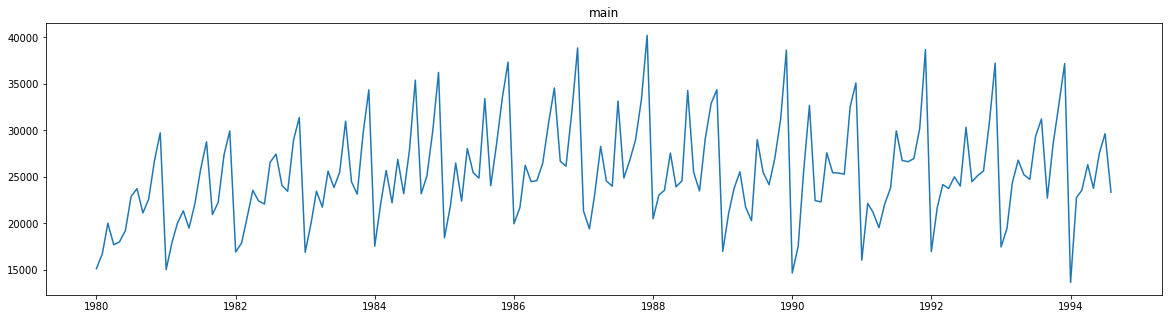

In [3]:
original_df = pd.read_csv("data/monthly-australian-wine-sales.csv")
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df=df, freq="MS")
ts.plot()

## 2. Build Pipelines <a class="anchor" id="chapter2"></a>

Given the sales' history, we want to select the best model(pipeline) to forecast future sales.

In [4]:
from etna.pipeline import Pipeline
from etna.models import NaiveModel, SeasonalMovingAverageModel, ProphetModel, CatBoostModelMultiSegment
from etna.transforms import LagTransform
from etna.metrics import MAE, MSE, SMAPE, MAPE
HORIZON = 3
N_FOLDS = 5

Let's build four pipelines using the different models

In [5]:
naive_pipeline = Pipeline(model=NaiveModel(lag=12), transforms=[], horizon=HORIZON)
seasonalma_pipeline = Pipeline(
    model=SeasonalMovingAverageModel(window=5, seasonality=12), transforms=[], horizon=HORIZON
)
prophet_pipeline = Pipeline(model=ProphetModel(), transforms=[], horizon=HORIZON)
catboost_pipeline = Pipeline(
    model=CatBoostModelMultiSegment(),
    transforms=[LagTransform(lags=[6, 7, 8, 9, 10, 11, 12], in_column="target")],
    horizon=HORIZON,
)
pipeline_names = ["naive", "moving average", "prophet", "catboost"]
pipelines = [naive_pipeline, seasonalma_pipeline, prophet_pipeline, catboost_pipeline]

And evaluate their performance on the backtest

In [6]:
metrics = []
for pipeline in pipelines:
    metrics.append(
        pipeline.backtest(
            ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()], n_folds=N_FOLDS, aggregate_metrics=True, n_jobs=5
        )[0].iloc[:, 1:]
    )
metrics = pd.concat(metrics)
metrics.index = pipeline_names
metrics

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    9.5s remaining:    6.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.6s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    9.2s remaining:    6.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.


,MAE,MSE,SMAPE,MAPE
naive,2437.466667,1.089199e+07,9.949886,10.222106
moving average,1913.826667,6.113701e+06,7.897570,7.824056
prophet,2174.839053,6.577668e+06,8.891147,9.047454
catboost,2224.661062,8.699304e+06,9.095614,9.733325


## 3. Ensembles <a class="anchor" id="chapter3"></a>
To improve the performance of the individual models, we can try to make ensembles out of them. Our library contains two ensembling methods, which we will try on now.

### 3.1 VotingEnsemble<a class="anchor" id="section_3_1"></a>

`VotingEnsemble` forecasts future values with weighted averaging of it's `pipelines` forecasts.

In [7]:
from etna.ensembles import VotingEnsemble

By default, `VotingEnsemble` uses **uniform** weights for the pipelines' forecasts.

In [8]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, n_jobs=4)

In [9]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()], n_folds=N_FOLDS, aggregate_metrics=True, n_jobs=2
)[0].iloc[:, 1:]
voting_ensamble_metrics.index = ["voting ensemble(uniform weights)"]
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   11.2s remaining:    7.5s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.3s finished


,MAE,MSE,SMAPE,MAPE
voting ensemble(uniform weights),2089.214327,7.245760e+06,8.594828,8.83881


You can specify the `weights` manually, the higher weight the more you trust the base model. The `weights` are automatically normalized.

In [10]:
voting_ensemble_custom_weights = VotingEnsemble(pipelines=pipelines, weights=[1, 16, 9, 4], n_jobs=4)

In [11]:
voting_ensamble_custom_weights_metrics = voting_ensemble_custom_weights.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()], n_folds=N_FOLDS, aggregate_metrics=True, n_jobs=2
)[0].iloc[:, 1:]
voting_ensamble_custom_weights_metrics.index = ["voting ensemble(custom weights)"]
voting_ensamble_custom_weights_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   11.5s remaining:    7.6s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.5s finished


,MAE,MSE,SMAPE,MAPE
voting ensemble(custom weights),1961.713172,6.152859e+06,8.094123,8.19029


### 3.2 StackingEnsemble<a class="anchor" id="section_3_2"></a>
`StackingEnsemble` forecasts future using the metamodel to combine the forecasts of it's `pipelines`.

In [12]:
from etna.ensembles import StackingEnsemble

By default, `StackingEnsemble` uses only the pipelines' forecasts as features for the `final_model`.

In [13]:
stacking_ensemble_unfeatured = StackingEnsemble(pipelines=pipelines, cv=10, n_jobs=4)

In [14]:
stacking_ensamble_unfeatured_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()], n_folds=N_FOLDS, aggregate_metrics=True, n_jobs=2
)[0].iloc[:, 1:]
stacking_ensamble_unfeatured_metrics.index = ["stacking ensemble"]
stacking_ensamble_unfeatured_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   27.2s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   32.0s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   50.6s remaining:   33.7s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


,MAE,MSE,SMAPE,MAPE
stacking ensemble,2002.657375,7.227136e+06,8.329696,8.461256


However, sometimes it might be useful to combine them with the other features, which were used to fit the base models. You can specify the additional features using the `features_to_use` parameter.

In [15]:
stacking_ensemble_featured = StackingEnsemble(pipelines=pipelines, cv=10, features_to_use="all", n_jobs=4)

In [16]:
stacking_ensamble_featured_metrics = stacking_ensemble_featured.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()], n_folds=N_FOLDS, aggregate_metrics=True, n_jobs=2
)[0].iloc[:, 1:]
stacking_ensamble_featured_metrics.index = ["stacking ensemble + features"]
stacking_ensamble_featured_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   29.8s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   35.8s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   53.3s remaining:   35.5s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished


,MAE,MSE,SMAPE,MAPE
stacking ensemble + features,2012.246021,7.284254e+06,8.292619,8.525519


In addition, it is also possible to specify the `final_model`. You can use any regression model with the sklearn interface for this purpose.

In [17]:
from sklearn.linear_model import Lasso

In [18]:
stacking_ensemble_final_model = StackingEnsemble(
    pipelines=pipelines, final_model=Lasso(alpha=10), cv=10, features_to_use="all", n_jobs=4
)

In [19]:
stacking_ensamble_final_model_metrics = stacking_ensemble_final_model.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()], n_folds=N_FOLDS, aggregate_metrics=True, n_jobs=2
)[0].iloc[:, 1:]
stacking_ensamble_final_model_metrics.index = ["stacking ensemble + features + lasso"]
stacking_ensamble_final_model_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   29.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   35.1s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   52.3s remaining:   34.8s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished


,MAE,MSE,SMAPE,MAPE
stacking ensemble + features + lasso,2012.24469,7.284238e+06,8.292615,8.525514


### 3.3 Results<a class="anchor" id="section_3_3"></a>
Finally, let's take a look at the results of our experiments

In [20]:
metrics = pd.concat(
    [
        metrics,
        voting_ensamble_metrics,
        voting_ensamble_custom_weights_metrics,
        stacking_ensamble_unfeatured_metrics,
        stacking_ensamble_featured_metrics,
        stacking_ensamble_final_model_metrics,
    ]
)
metrics


,MAE,MSE,SMAPE,MAPE
naive,2437.466667,1.089199e+07,9.949886,10.222106
moving average,1913.826667,6.113701e+06,7.897570,7.824056
prophet,2174.839053,6.577668e+06,8.891147,9.047454
catboost,2224.661062,8.699304e+06,9.095614,9.733325
voting ensemble(uniform weights),2089.214327,7.245760e+06,8.594828,8.838810
voting ensemble(custom weights),1961.713172,6.152859e+06,8.094123,8.190290
stacking ensemble,2002.657375,7.227136e+06,8.329696,8.461256
stacking ensemble + features,2012.246021,7.284254e+06,8.292619,8.525519
stacking ensemble + features + lasso,2012.244690,7.284238e+06,8.292615,8.525514
